# Correlation Between Volatility of Bitcoin and Doge
## Hypothesis:
    + Doge coin volatility is directly correlated to the popularity of Bitcoin
    + The volatility of coin price can be predicted in advance due to the time it takes for human recognition and action
    + Coin trade volume is foreshadowed in number of times a keywords are mentioned on Twitter (API limitations pivoted the project)

## Project Notes:
    + With limited resources, the inability to use paid APIs to specify data to smaller increments, bases the model off of daily change. In theory, daily change wont be able to catch exactly when surge occurs, minute or hour increments would be far more useful.
    + Limited to using daily volume and assuming that large spikes in volume are due to popularity on social media and news platforms.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

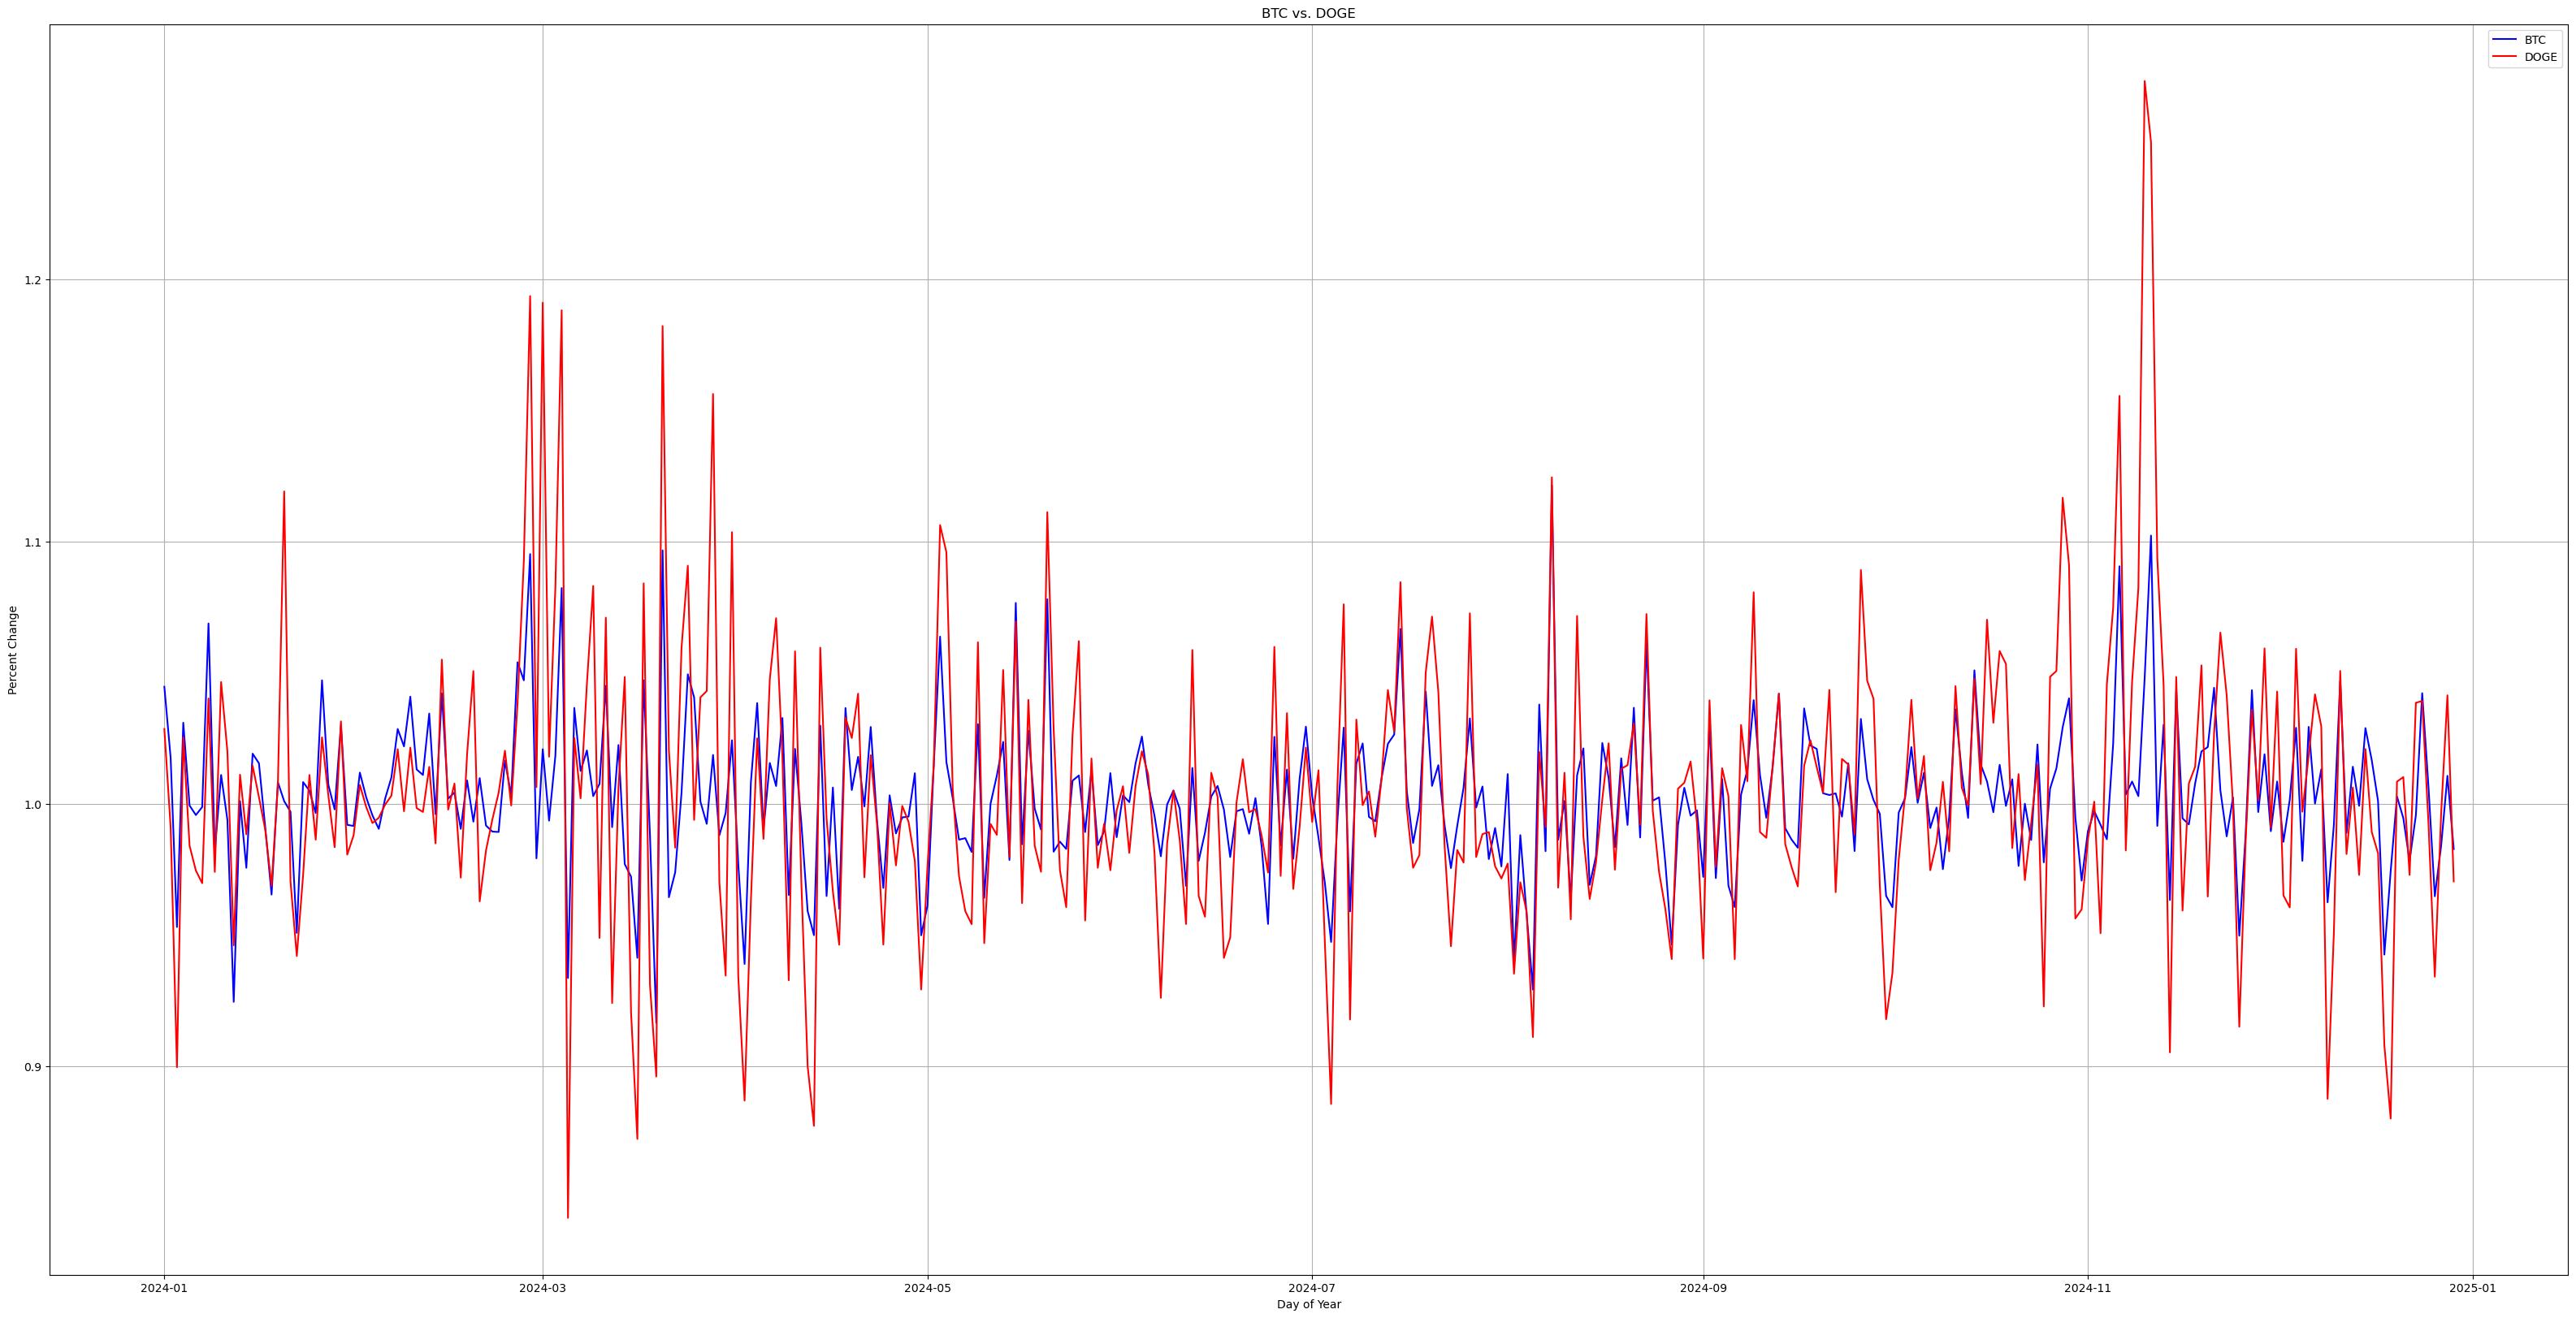

In [4]:
#Importing data using white space ignoring delimiter to import raw string literal
#setting a simple tab delimiter was causes errors in several places
bitcoinData = pd.read_csv('bitcoinHistorical.txt', delimiter=r'\s+', engine='python')
dogeData = pd.read_csv('dogeHistorical.txt', delimiter=r'\s+', engine='python')

#Was an error reading columns due to white space so using to remove any excess from column names
bitcoinData.columns = bitcoinData.columns.str.strip()
dogeData.columns = dogeData.columns.str.strip()

#Convert 'Open' and 'Close' columns to numeric (in case they are not already)
#coerce to make invalid numbers show up as NaN for error handling
bitcoinData['Open'] = pd.to_numeric(bitcoinData['Open'], errors='coerce')
bitcoinData['Close'] = pd.to_numeric(bitcoinData['Close'], errors='coerce')
dogeData['Open'] = pd.to_numeric(dogeData['Open'], errors='coerce')
dogeData['Close'] = pd.to_numeric(dogeData['Close'], errors='coerce')

#calculate the percentage of change the coins see within a given day
bitcoinData['Percent Change'] = ((bitcoinData['Close'] - bitcoinData['Open']) / bitcoinData['Open']) * 100
dogeData['Percent Change'] = ((dogeData['Close'] - dogeData['Open']) / dogeData['Open']) * 100

# Normalize the percentage change data to bring both coins onto a similar scale
bitcoinData['Normalized Percent Change'] = ((bitcoinData['Percent Change'] + 100) / 100)
dogeData['Normalized Percent Change'] = ((dogeData['Percent Change'] + 100) / 100)

#used to force the input files date to the correct format, was getting errors without explicitly setting format (mm.dd.yyyy)
bitcoinData['Date'] = pd.to_datetime(bitcoinData['Date'], format='%m.%d.%y')
dogeData['Date'] = pd.to_datetime(dogeData['Date'], format='%m.%d.%y')

#Setting "Date" to the index
bitcoinData.set_index('Date', inplace=True)
dogeData.set_index('Date', inplace=True)

#Setting the day of the year for the x axis, changes the column for tracking date to "DayOfYear"
bitcoinData['DayOfYear'] = bitcoinData.index.dayofyear
dogeData['DayOfYear'] = dogeData.index.dayofyear

#plotting the figure
plt.figure(figsize=(40, 20)) #larger data size needs larger figsize for visual rep.

#plot the closing price from the txt files
plt.plot(bitcoinData.index, bitcoinData['Normalized Percent Change'], label = 'BTC', color = 'blue')
plt.plot(dogeData.index, dogeData['Normalized Percent Change'], label = 'DOGE', color = 'red')

#visualization of the graph
plt.xlabel('Day of Year')
plt.ylabel('Percent Change')
plt.title('BTC vs. DOGE')

#grid and legend
plt.grid(True)
plt.legend()

#print the plot
plt.show()

Notes: Coin volatility is almost a perfect mirror of each other when data is normalized. Original model was going to implement trending twitter topics to help predict spikes even faster. The increased volatility of Doge over Bitcoin is most likely attributed to the coin price being so low and the ability to purchase much larger quantities.  

#file size was too large with trade volume included, importing with another file to avoid input issues
#was in original plans but absence of twitter data has made it unnecessary, keeping in if I get access for Twitter API 
bitcoinVolume = pd.read_csv('bitcoinVolume.txt', delimiter=r'\s+')
dogeVolume = pd.read_csv('dogeVolume.txt', delimiter=r'\s+')
#print(bitcoinVolume.head(5)) #testing bitcoin data input
#print(dogeVolume.head(5)) #testing doge data inputs
#switch to code instead of markdown to apply

## Price Prediction Algorithm Doge
### Notes:
    + This model is used to show how closely related the two coin prices are by ignoring the changes in doge coin and buying strictly based off percent changes in bitcoin.


In [65]:
#simulation variables:
setDay = 1 #how many days into the year to start simulation, will automatically track to year end (2024 only)
                #"Date" column was set to the index in the previous model so to select day the index will have to be used

investment = 10000.00 #initial investment value

#adding a down day counter to data sheet for sell order conditions
bitcoinData['Consecutive Down Days'] = 0 #initialize the column for tracking down days
daysCount = 0 #local variable for counter 
for i in range(len(bitcoinData)):
    if bitcoinData['Percent Change'].iloc[i] < 0:
        daysCount += 1
    else:
        daysCount = 0
    bitcoinData.iloc[i, bitcoinData.columns.get_loc('Consecutive Down Days')] = daysCount #had to use get_loc instead of .loc
    #was creating another row with the index and value instead of adjusting the correct column

def coinCount(dogeData, investment, setDay): #set day will update in buy/sell orders to keep track of coin price
    coinPrice = dogeData.loc[dogeData['DayOfYear'] == setDay, 'Open'].values[0] #accessing the value of the opening coin price at the date
    return investment / coinPrice 

currentCoins = coinCount(dogeData, investment, setDay) #initialize coins from initial investment

def sellOrder(bitcoinData, dogeData, investment, setDay, currentCoins): #returns value of coins sold
    for i in range(setDay, len(bitcoinData)):
        if bitcoinData['Consecutive Down Days'].iloc[i] >= 3:
            investment = (dogeData['Close'].iloc[i] * currentCoins)
            setDay = i + 1
            print(f"Sell order of Doge coin at {dogeData['Close'].iloc[i]} on day {i}.")
            return investment, setDay, True #returns to and values to track successful selling days
    return investment, setDay, False #returns false and original values

def buyOrder(bitcoinData, dogeData, investment, setDay, currentCoins): #returns the number of coins owned
    for i in range(setDay, len(bitcoinData)):
        if i+1 < len(dogeData):
            if bitcoinData['Consecutive Down Days'].iloc[i] == 0: #buying after down days end, tracks change between days so purchase needs to be made next day for validity
                currentCoins = (investment / (dogeData['Open'].iloc[i+1])) #buy the opening price for next day
                setDay = i+1
                print(f"Buy order of Doge coin at {dogeData['Open'].iloc[i+1]} on day {i+1}.")
                return currentCoins, setDay, True #successful buy had occurred and values are returned
    return currentCoins, setDay, False #no action taken, original values returned

def finalSell(bitcoinData, dogeData, investment, setDay, currentCoins):
    sellPrice = dogeData.loc[dogeData['DayOfYear'] == setDay, 'Close'].values[0]
    return (currentCoins * sellPrice)

#final simulation takes in two variables, the investment and the setDay. Returns two variables, currentCoins and the setDay
def simulateInvestment(bitcoinData, dogeData, investment, setDay, currentCoins):
    initialInvestment = investment
    currentCoins = coinCount(dogeData, investment, setDay) #initialize coins from initial investment
    sold = False #initialize sold position

    print("Buy/Sell Order Data:")
    while setDay < len(bitcoinData):
        investment, setDay, hasSold = sellOrder(bitcoinData, dogeData, investment, setDay, currentCoins)
        if hasSold:
            sold = True #indicate a sell has occurred
            currentCoins, setDay, sold = buyOrder(bitcoinData, dogeData, investment, setDay, currentCoins) #after the sale buy when condition is met
            sold = False
        
        if not hasSold and not sold: #exit the loop when none of the conditions are met and the data frame has reached the end
            #calculate the final balance
            balance = finalSell(bitcoinData, dogeData, investment, setDay, currentCoins)
            print(f"Final sell order of Doge coin at {dogeData.loc[dogeData['DayOfYear'] == setDay, 'Close'].values[0]} on day {setDay}.")
            print("\nYear end reached! Here's how your investment performed:")
            break

    #calculating percent increase over investment period
    percentChange = ((balance - initialInvestment) / initialInvestment) * 100

    #print out investment details(:.2f to format USD)
    profit = balance - initialInvestment
    print(f"Initial investment: $ {initialInvestment:.2f}")
    print(f"Final balance: ${balance:.2f}")
    print(f"You made a profit of: ${profit:.2f}")
    print(f"Percent increase: {percentChange:.1f}%")
    
    return balance #returns final balance after the year ends


#simulate the year of investing (2024 data)
simulate = simulateInvestment(bitcoinData, dogeData, investment, setDay, currentCoins)
#bitcoinData.to_csv('data.txt', sep='\t') #used to manually check buy/sell days are working correctly

Buy/Sell Order Data:
Sell order of Doge coin at 0.078225 on day 6.
Buy order of Doge coin at 0.081378 on day 8.
Sell order of Doge coin at 0.084434 on day 53.
Buy order of Doge coin at 0.086157 on day 55.
Sell order of Doge coin at 0.142368 on day 75.
Buy order of Doge coin at 0.154328 on day 77.
Sell order of Doge coin at 0.153168 on day 103.
Buy order of Doge coin at 0.162285 on day 105.
Sell order of Doge coin at 0.146699 on day 118.
Buy order of Doge coin at 0.143492 on day 120.
Sell order of Doge coin at 0.143294 on day 128.
Buy order of Doge coin at 0.152117 on day 130.
Sell order of Doge coin at 0.159613 on day 143.
Buy order of Doge coin at 0.163804 on day 145.
Sell order of Doge coin at 0.146059 on day 159.
Buy order of Doge coin at 0.146767 on day 161.
Sell order of Doge coin at 0.122341 on day 170.
Buy order of Doge coin at 0.123783 on day 174.
Sell order of Doge coin at 0.104887 on day 185.
Buy order of Doge coin at 0.113577 on day 188.
Sell order of Doge coin at 0.128088 o